In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import math
import itertools
from time import time
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
data_dir = "../data/markup_data/ad_control"

In [3]:
cilia = []
with open("cilia.pkl", "rb") as file:
    cilia = pickle.load(file)
    
for f in cilia:
    for l in f:
        l.append(math.sqrt((l[0] - l[2])**2 + (l[1] - l[3])**2))
        l.append(int("AD" in l[5] or "Ad" in l[5]))

In [4]:
relationships = []

for i, img_path in enumerate(os.listdir(data_dir)):
    img_path = data_dir + "/" + img_path
    img = cv2.imread(img_path)
    
    for lines in itertools.combinations(cilia[i], 2):
        a1 = lines[0][3] - lines[0][1]
        b1 = lines[0][0] - lines[0][2]
        c1 = a1*lines[0][0] + b1*lines[0][1]
        
        a2 = lines[1][3] - lines[1][1]
        b2 = lines[1][0] - lines[1][2]
        c2 = a2*lines[1][0] + b2*lines[1][1]
        
        determinant = a1*b2 - a2*b1
        
        distance = min([min(math.sqrt((lines[0][0] - line[0])**2 + (lines[0][1] - line[1])**2),
                      math.sqrt((lines[0][2] - line[2])**2 + (lines[0][3] - line[3])**2)) 
                      for line in itertools.permutations(lines[1][:4], 4)])
        
        if determinant != 0:
            x = (c1*b2 - c2*b1)/determinant
            y = (a1*c2 - a2*c1)/determinant

            d1 = min(math.sqrt((lines[0][0] - x)**2 + (lines[0][1] - y)**2),
                     math.sqrt((lines[0][2] - x)**2 + (lines[0][3] - y)**2))
            d2 = min(math.sqrt((lines[1][0] - x)**2 + (lines[1][1] - y)**2),
                     math.sqrt((lines[1][2] - x)**2 + (lines[1][3] - y)**2))
            
            v1 = np.array([lines[0][0] - lines[0][2], lines[0][1] - lines[0][3]])
            v2 = np.array([lines[1][0] - lines[1][2], lines[1][1] - lines[1][3]])
            
            dot_product = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
            angle = 180 * np.arccos(dot_product) / np.pi
            
            if d1 < 12 and d2 < 12:
                relationships.append([lines[0][4], lines[1][4], angle, distance])
                lines[0].append(angle)
                lines[1].append(angle)
                lines[0].append(distance)
                lines[1].append(distance)
            
            if 0 <= x <= 1000 and 0 <= y <= 1000:
                img = cv2.circle(img, (int(x),int(y)), 1, (0,255,0), -1)
        else:
            angle = 180
            
            if distance < 6:
                relationships.append([lines[0][4], lines[1][4], angle, distance])
                lines[0].append(angle)
                lines[1].append(angle)
                lines[0].append(distance)
                lines[1].append(distance)

In [5]:
cilia_df = pd.DataFrame([c for f in cilia for c in f], 
                        columns=["x1", "y1", "x2", "y2", "ID", "filename", 
                                 "length", "AD", "angle1", "segmentation1", 
                                 "angle2", "segmentation2"])
relationships_df = pd.DataFrame(relationships, columns=["cilia1", "cilia2", "angle", "distance"])

num_relationships = []
for i in cilia_df["ID"]:
    if i in list(relationships_df["cilia1"]):
        num_relationships.append(relationships_df["cilia1"].value_counts()[i])
    else:
        num_relationships.append(0)
    if i in list(relationships_df["cilia2"]):
        num_relationships[i] += relationships_df["cilia2"].value_counts()[i]
    
cilia_df["relationships"] = num_relationships

cilia_df = cilia_df.reindex(columns=["ID", "filename", "length", "relationships",
                                     "angle1", "segmentation1", "angle2", 
                                     "segmentation2", "AD"])
cilia_df.fillna(-1, inplace=True)

In [6]:
cilia_df.to_csv("cilia.csv")

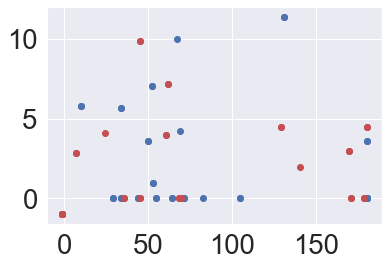

In [28]:
#plt.hist(cilia_df[cilia_df["AD"] == 1]["length"], alpha=0.5, bins=range(0, 33, 3))
plt.plot(cilia_df[cilia_df["AD"] == 0]["angle1"], cilia_df[cilia_df["AD"] == 0]["segmentation1"], "bo")
plt.plot(cilia_df[cilia_df["AD"] == 1]["angle1"], cilia_df[cilia_df["AD"] == 1]["segmentation1"], "ro")

In [21]:
X = np.array(cilia_df[["length", "relationships", "angle1", "segmentation1"]])
y = np.array(cilia_df["AD"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [23]:
models = [('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB())]
dfs = []

results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['AD', 'No AD']
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))

results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name

dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

/home/dchanana/Projects/sciFair2022/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogReg
              precision    recall  f1-score   support

          AD       0.38      0.71      0.50         7
       No AD       0.00      0.00      0.00         8

    accuracy                           0.33        15
   macro avg       0.19      0.36      0.25        15
weighted avg       0.18      0.33      0.23        15

RF
              precision    recall  f1-score   support

          AD       0.56      0.71      0.63         7
       No AD       0.67      0.50      0.57         8

    accuracy                           0.60        15
   macro avg       0.61      0.61      0.60        15
weighted avg       0.61      0.60      0.60        15

KNN
              precision    recall  f1-score   support

          AD       0.44      0.57      0.50         7
       No AD       0.50      0.38      0.43         8

    accuracy                           0.47        15
   macro avg       0.47      0.47      0.46        15
weighted avg       0.47      0.47      0.46        15

SVM
 

/home/dchanana/Projects/sciFair2022/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dchanana/Projects/sciFair2022/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dchanana/Projects/sciFair2022/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dchanan

(array([46.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 30 artists>)

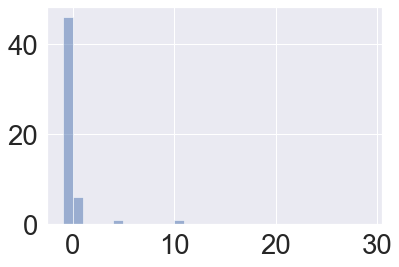

In [42]:
#plt.hist(cilia_df[cilia_df["AD"] == 1]["length"], alpha=0.5, bins=range(0, 33, 3))
plt.hist(cilia_df[cilia_df["AD"] == 0]["segmentation2"], bins=range(-1,30), alpha=0.5)

(array([40.,  0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 30 artists>)

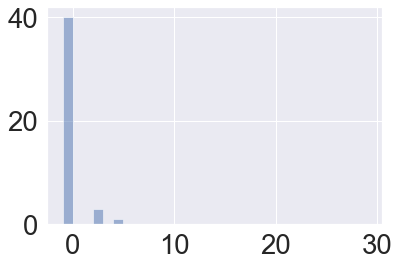

In [43]:
plt.hist(cilia_df[cilia_df["AD"] == 1]["segmentation2"], bins=range(-1,30), alpha=0.5)